# Homework 6 (Momentum)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
import scipy.stats as stats
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)


In [6]:

pd.set_option("display.precision", 4)
plt.style.use("seaborn")
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Section 2 (Investigating Momentum)

In [7]:
file_path = 'C:/Users/dcste/OneDrive/Portfolio_Theory/Homework_Jupyter\portfolio_theory\momentum_data.xlsx'
momentum_info = pd.read_excel(file_path, sheet_name = 'descriptions')
momentum_info = momentum_info.rename(columns = {'Unnamed: 0': "Factor"})
momentum_info

,Factor,Name,Unit,Construction,Description
0,MKT,Market,Excess Return,Market-cap-weighted,US Equities
1,SMB,Size,Excess Return,Small Minus Big,Long small stocks and short big stocks
2,HML,Value,Excess Return,High Minus Low,Long value (high book-to-market) stocks and sh...
3,RF,Risk-free rate,Total Return,Tbills,NaN
4,SMALL LoPRIOR,Small Down,Total Return,Small Losers,Bottom 3 deciles and Small
5,SMALL HiPRIOR,Small Up,Total Return,Small Winners,Top 3 deciles and Small
6,BIG LoPRIOR,Big Down,Total Return,Big Losers,Bottom 3 deciles and Big
7,BIG HiPRIOR,Big Up,Total Return,Big Winners,Top 3 deciles and Big


## Is Momentum Profitable

- Have momentum returns changed since 2009-2022 (the time this case occurred)?

In [8]:
# Import the momentum returns

df_mom_size = pd.read_excel(file_path,parse_dates=True, sheet_name=2).set_index("Date")
ff_factors = pd.read_excel(file_path, sheet_name=1).set_index("Date")

df_mom_size = df_mom_size.join(ff_factors)
df_mom_size.head(4)

,UMD,MKT,SMB,HML
Date,,,,
1927-01-31,0.0036,-0.0006,-0.0037,0.0454
1927-02-28,-0.0214,0.0418,0.0004,0.0294
1927-03-31,0.0361,0.0013,-0.0165,-0.0261
1927-04-30,0.0430,0.0046,0.0030,0.0081


In [9]:
def table_row(df, portfolio, annualize_factor =12):
    mean = df[portfolio].mean()*annualize_factor
    vol = df[portfolio].std()*np.sqrt(annualize_factor)
    sharpe = mean/vol
    skew = df[portfolio].skew()
    corr = df[[portfolio, 'MKT','HML']].corr()
    corr_to_mkt = corr.loc[portfolio,'MKT']
    corr_to_value = corr.loc[portfolio,'HML']
    return [mean, vol, sharpe,skew, corr_to_mkt, corr_to_value]

table1 = pd.DataFrame(index=['1927-2022','1927-1993','1994-2008','2009-2022'], columns = ['mean', 'vol', 'sharpe','skew', 'corr_to_mkt', 'corr_to_value'])

table1.loc['1927-2022',:] = table_row(df_mom_size.loc['1927':'2022',:],portfolio='UMD')
table1.loc['1927-1993',:] = table_row(df_mom_size.loc['1927':'1993',:],portfolio='UMD')
table1.loc['1994-2008',:] = table_row(df_mom_size.loc['1994':'2008',:],portfolio='UMD')
table1.loc['2009-2022',:] = table_row(df_mom_size.loc['2009':'2022',:],portfolio='UMD')

table1

,mean,vol,sharpe,skew,corr_to_mkt,corr_to_value
1927-2022,0.0773,0.1626,0.4751,-3.0155,-0.3448,-0.4176
1927-1993,0.0901,0.16,0.5632,-3.809,-0.3625,-0.495
1994-2008,0.1044,0.1756,0.5945,-0.582,-0.2345,-0.1307
2009-2022,-0.0149,0.1593,-0.0932,-2.8116,-0.3779,-0.3852


## 2. Construct your own long-only implementation

$\tilde{r}^{momU:FF} = \frac{1}{2} \left( r^{momBU} + r^{momSU} \right) - r^f$

In [10]:
#import the data
df_port_mom = pd.read_excel(file_path, sheet_name=4).set_index("Date")
df_rf = pd.read_excel(file_path, sheet_name=5).set_index("Date")
df_port_mom = df_port_mom.join(df_rf)
df_port_mom.head(3)

,SMALL LoPRIOR,ME1 PRIOR2,SMALL HiPRIOR,BIG LoPRIOR,ME2 PRIOR2,BIG HiPRIOR,RF
Date,,,,,,,
1927-01-31,0.0008,0.0357,0.0040,-0.0040,0.0026,0.0000,0.0025
1927-02-28,0.0701,0.0648,0.0551,0.0727,0.0380,0.0447,0.0026
1927-03-31,-0.0346,-0.0288,-0.0206,-0.0357,-0.0018,0.0226,0.0030


In [11]:
#Constructing my own long-only implementation

df_port_mom['rx_mom_U_FF'] = (1/2 * (df_port_mom['BIG HiPRIOR']+df_port_mom['SMALL HiPRIOR']))-df_port_mom['RF']

df_mom_size['rx_mom_U_FF'] = df_port_mom['rx_mom_U_FF']

In [12]:
table2 = pd.DataFrame(index=['long_short', 'long_only'],
    columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])
table2.loc['long_short',:] = table_row(df_mom_size['1994':],portfolio='UMD')
table2.loc['long_only',:] = table_row(df_mom_size['1994':], portfolio='rx_mom_U_FF')

table2

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
long_short,0.0474,0.1686,0.2809,-1.4336,-0.3061,-0.2386
long_only,0.1128,0.1789,0.6304,-0.4829,0.9035,-0.1547


Text(0.5, 1.0, 'Figure 1: Cumulative Returns')

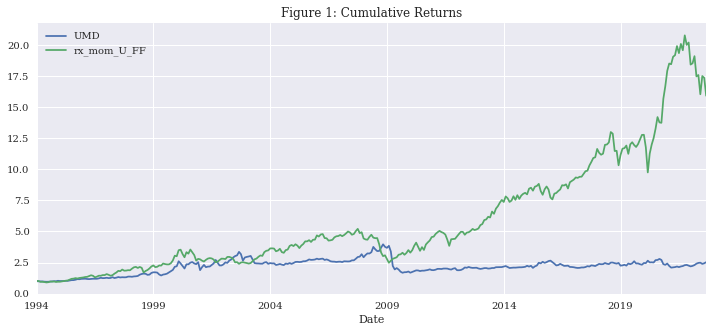

In [13]:
(1+ df_mom_size.loc['1994':,['UMD','rx_mom_U_FF']]).cumprod().plot(figsize = (12,5))
plt.title("Figure 1: Cumulative Returns")

- The long-only positions outperfrom on a risk-adjusted basis with a much higher mean return since 1994. It also has less skewness, which makes it look very attractive. 

- The correlation to the market is very high about .90, which means this portfolio is not a great diversifier. 

## 3. Is Momentum Just Data Mining?

- Assess how sensitive the threshold for the 'winners' and 'losers' is in the results. 
Compare these three constructions:

- long the top 1 decile and short the bottom 1 deciles

$\tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$

- long the top three deciles and short the bottom 3 deciles

$\tilde{r}^{momD3} = \frac{1}{3}\sum_{k=8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k=1}^{3} r^{mom(k)}$

- long the top 5 deciles and short the bottom 5 deciles


$\tilde{r}^{momD5} = \frac{1}{5}\sum_{k=6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k=1}^{5} r^{mom(k)}$